# Laboratorium 13 - Minimalizacja funkcji

##### Aleksandra Mazur

## Zadanie 1 Problem komiwojażera

#### Wygeneruj chmurę n losowych punktów w 2D, a następnie zastosuj algorytm symulowanego wyżarzania do przybliżonego rozwiązania problemu komiwojażera dla tych punktów.

#### a) Przedstaw wizualizacje otrzymanego rozwiązania dla 3 różnych wartości n oraz 3 róznych układów punktów w 2D (rozkład jednostajny, rozkład normalny z czterema różnymi grupami parametrów, dziewięć odseparowanych grup punktów).
#### b) Zbadaj wpływ sposobu generacji sąsiedniego stanu (consecutive swap - zamiana kolejności losowej pary połączonych wierzchołków w scieżce vs. arbitrary swap - zamiana dwóch losowych wierzchołków w scieżce) oraz początkowej wartości temperatury na zbieżność procesu optymalizacji.
#### c) Przedstaw wizualizacje działania procedury minimalizującej funkcje celu (funkcja przekazana do metody dual annealing może modyfikować zewnętrzny stan)

Do rozwiązania zadania użyto następujących funkcji:
* numpy
* random
* matplotlib
* math

In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
import math

Zastosowano algorytm wyżarzania do przybliżonego rozwiązania problemu komiwojażera (TSP). 

Problem komiwojażera to zagadnienie optymalizacyjne, polegające na znalezieniu minimalnego cyklu Hamiltona w pełnym grafie ważonym. W tym przypadku sprowadza się on do znalezienia cyklu przechodzącego przez wszystkie wierzchołki o najkrótszej ścieżce.

Z kolei algorytm symulowanego wyżarzania opiera się na ciągłym ulepszaniu istniejącego rozwiązania do momentu, gdy nie udaje się go dalej poprawić. Przejście z jednego rozwiązania do drugiego jest realizowane przez tzw. funkcję przejścia i polega na znalezieniu rozwiązania sąsiedniego, co jest zależne od problemu, w którym algorytm jest zastosowany.

Ścieżka była reprezentowana przez tablicę wierzchołków (sąsiedztwo dwóch wierzchołków w tablicy oznacza, że jest między nimi krawędź, istnieje także krawędź między pierwszym i ostatnim wierzchołkiem w tablicy). Generacja stanu sąsiedniego została przetestowana w dwóch wariantach: w pierwszym, *consecutive swap*, zamieniano sąsiednie wierzchołki miejscami. W drugim wariancie, *abribtrary swap*, wierzchołki do zamiany były wybierane losowo.

Program przetestowano dla trzech rozkładów punktów na płasczyźnie: rozkład jednostajny, rozkład normalny, 9 grup wierzchołków. W każdym z rozkładów rozpatrzono 3 różne liczby wierzchołków.

Wykonano także wykresy zależności energii w zależności od liczby iteracji pętli algorytmu wyżarzania.

Poniższe funkcje generują *n* losowych punktów w 2D:
* **generate_uniform** - punkty o rozkładzie jednostajnym
* **generate_normal** - punkty o rozkładzie normalnym z wartością oczekiwaną *m* i odchyleniem standardowym *sigma*
* **generate_nine** - dziewięć odseparowanych grup punktów

In [2]:
def generate_uniform(n, low=0, high=50):
    points = []
    for i in range(n):
        points.append([np.random.uniform(low, high), np.random.uniform(low, high)])
    random.shuffle(points)
    return np.array(points)

def generate_normal(n):
    points = []
    mu = [0, 2, 10, 20]
    sigma = [10, 12, 20, 50]
    for i in range(4):
        for j in range(int(n/4)):
            points.append([np.random.normal(mu[i], sigma[i]), np.random.normal(mu[i], sigma[i])])
            
    while len(points) != n:
        i = random.randint(0, 3)
        points.append([np.random.normal(mu[i], sigma[i]), np.random.normal(mu[i], sigma[i])])

    random.shuffle(points)
    return np.array(points)

def generate_nine(n):
    pairs = [[1,2], [4,5], [7,8]]
    points = []
    for x in pairs:
        for y in pairs:
            for i in range(int(n/9)):
                points.append([np.random.uniform(x[0], x[1]), np.random.uniform(y[0], y[1])])
    
    if len(points) != n:
        for x in pairs:
            for y in pairs:
                for i in range(int(n/9)):
                    points.append([np.random.uniform(x[0], x[1]), np.random.uniform(y[0], y[1])])
                    if len(points) == n:
                        random.shuffle(points)
                        return np.array(points)
    
    random.shuffle(points)
    return np.array(points)        

Funkcja pomocnicza **distance** - oblicza odległość między dwoma punktami *p* i *q*.

In [3]:
def distance(p, q):
    return np.sqrt((p[0] - q[0]) ** 2 + (p[1] - q[1]) ** 2)

Funkcja **count_energy** oblicza długość ścieżki złożonej z punktów znajdujących się w tablicy *x*. Dodatkowo funkcja ta zapisuje do globalnej tablicy *energies* obliczoną długość ścieżki w celu późniejszej wizualizacji, jeżeli w argumencie *add_energy* jest wartość *True*.

In [4]:
def count_energy(x, add_energy=False):
    energy = 0
    N = len(x)
    for k in range(N):
        energy += distance(x[k], x[(k + 1) % N])
    if add_energy:
        energies.append(energy)
    return energy

Funkcja **show_result** przyjmuje wektor *result* zawierający punkty w optymalnej kolejności i zmienne informacyjne. Na tej podstawie jest przedstawiona wizualizacja uzyskanej ścieżki. Dodatkowo przedstawiono na wykresie ścieżkę losową przechodzącą przez wszystkie punkty. Dla obu przypadków wypisano również długość ścieżek. Funkcja ta przedstawia też na wykresie wizualizację działania procedury minimalizującej, czyli kolejne długości ścieżek obliczane przez funkcję *simulated_annealing*.

In [5]:
def show_result(result, show_random, name):
    print("N = ", len(result))
    fig, ax = plt.subplots(1,2, figsize=[20,10])
    
    # Random path
    if show_random:
        xs = [p[0] for p in points]
        ys = [p[1] for p in points]
        xs.append(xs[0]) # dodano na koniec pierwszy punkt
        ys.append(ys[0])

        energy_random = 0 # obliczenie długości śieżki dla losowego ułożenia punktów
        N = len(points)
        for k in range(N):
            energy_random += distance(points[k], points[(k + 1) % N])

        ax[0].plot(xs, ys, 'co')
        ax[0].plot(xs, ys, linewidth=1, color='black')
        ax[0].set_title(f'Random path, length: {energy_random}')
        ax[0].set_xlabel('x')
        ax[0].set_ylabel('y')
    
    # TSP path
    xs = [p[0] for p in result]
    ys = [p[1] for p in result]
    xs.append(xs[0])
    ys.append(ys[0])
    
    energy_TSP = 0 # obliczenie długości optymalnej ścieżki
    N = len(result)
    for k in range(N):
        energy_TSP += distance(result[k], result[(k + 1) % N])
    
    if show_random:
        ax[1].plot(xs, ys, 'co')
        ax[1].plot(xs, ys, linewidth=1, color='black')
        ax[1].set_title(f'TSP {name}, length: {energy_TSP}')
        ax[1].set_xlabel('x')
        ax[1].set_ylabel('y')
        plt.show()
        
        # Energies plot
        plt.figure(figsize=(8, 8))
        plt.plot(energies)
        plt.xlabel('Iteration')
        plt.ylabel('Energy')
        plt.title('Energies')
        plt.show()
    else:
        ax[0].plot(xs, ys, 'co')
        ax[0].plot(xs, ys, linewidth=1, color='black')
        ax[0].set_title(f'TSP {name}, length: {energy_TSP}')
        ax[0].set_xlabel('x')
        ax[0].set_ylabel('y')
    
        # Energies plot
        ax[1].plot(energies)
        ax[1].set_xlabel('Iteration')
        ax[1].set_ylabel('Energy')
        ax[1].set_title('Energies')
        plt.show()

Funkcja **simulated_annealing** przyjmuje nazwę metody dokonującej zamianę punktów *swap_method*, temperaturę maksymalną *temp_max*, mnożnik do zmniejszania temperatury *multiplier*, maksymalną liczbę iteracji *k_max* oraz zmienne informacyjne (*show_random*, *name*). Funkcja implementuje algorytm symulowanego wyżarzania w celu znalezienia najkrótszej ścieżki między danymi punktami i wizualizuje uzyskane efekty.

In [6]:
def simulated_annealing(swap_mode='arbitrary', temp_max=1000, multiplier=0.003, k_max = 10000, show_random=True, name=""):
    n = len(points)
    new_points = points.copy()
    i = -1
    t = temp_max
    
    for k in range(k_max):
        
        if swap_mode == 'arbitrary':
            i = random.randint(0, n - 1)
            j = random.randint(0, n - 1)
            while i == j:
                i = random.randint(0, n - 1)
                
        elif swap_mode == 'consecutive':
            i = (i + 1) % n
            j = (i + 1) % n
            
        old_energy = count_energy(new_points, True)
        new_points[[i, j]] = new_points[[j, i]]
        new_energy = count_energy(new_points, False)

        if new_energy > old_energy and math.exp(-abs(new_energy - old_energy) / t) < random.random():
            new_points[[i, j]] = new_points[[j, i]]
        
        t = t * (1 - multiplier)

    show_result(new_points, show_random, name)

## Liczba punktów: N = 10
### Rozkład jednostajny

N =  10


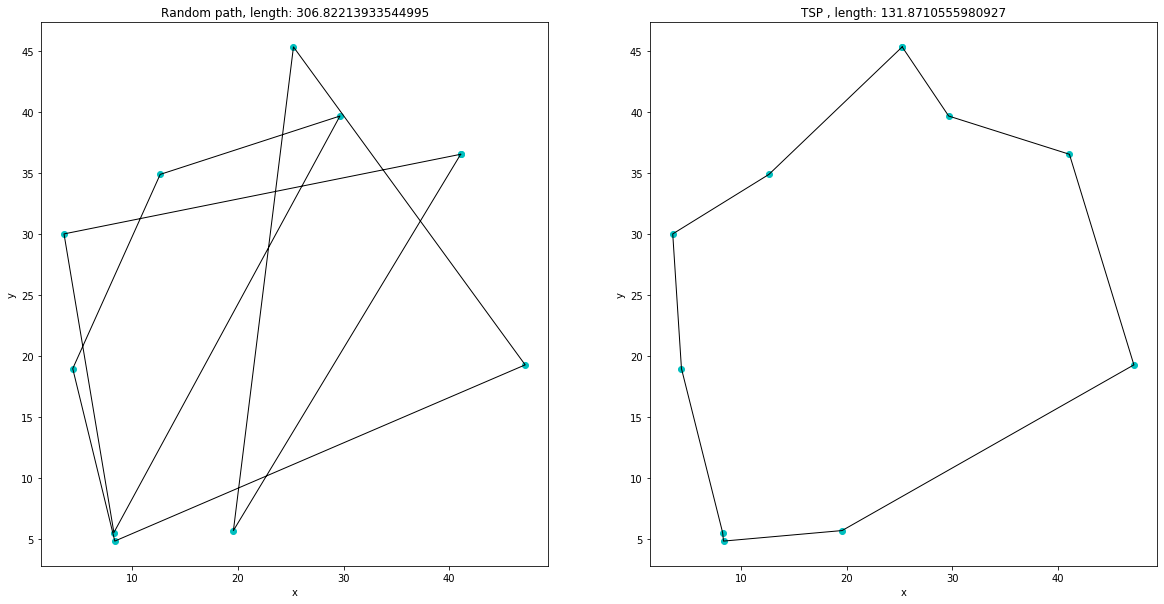

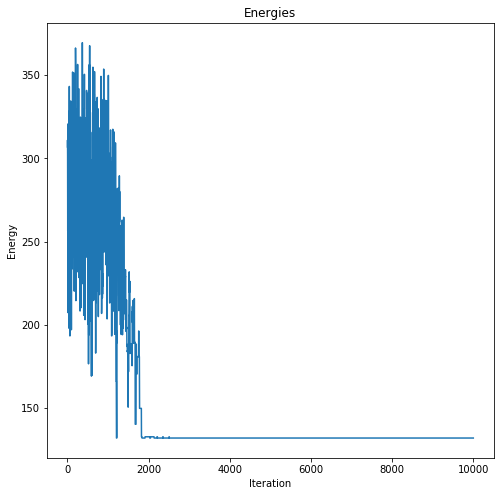

In [7]:
N = 10
points = generate_uniform(N)
energies = []
simulated_annealing()

### Rozkład normalny z czterema różnymi grupami parametrów

N =  10


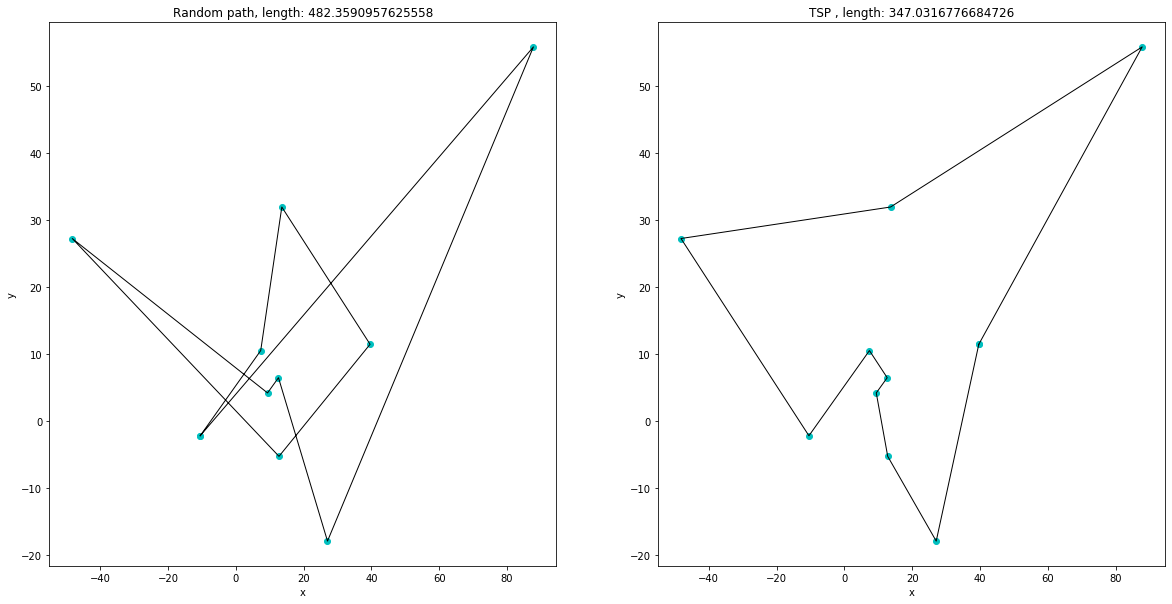

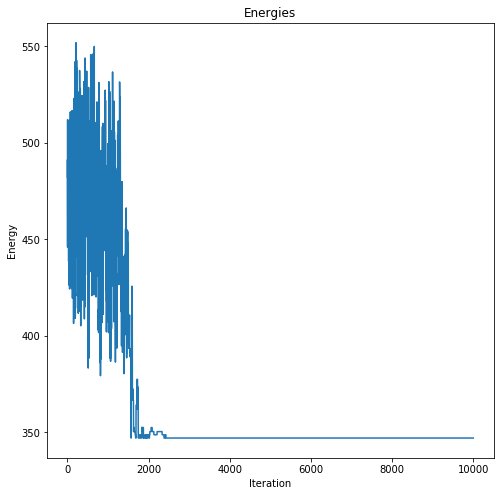

In [8]:
points = generate_normal(N)
energies = []
simulated_annealing()

### Dziewięć odseparowanych grup punktów

N =  10


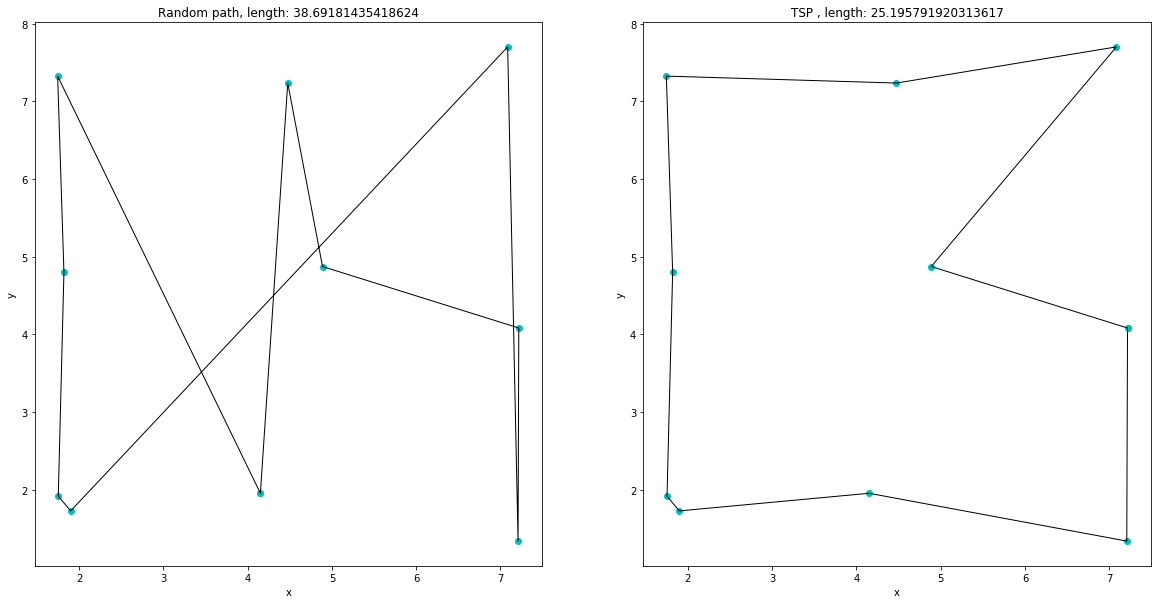

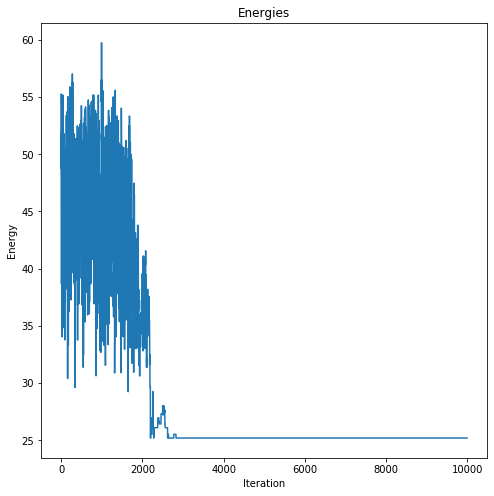

In [9]:
points = generate_nine(N)
energies = []
simulated_annealing()

## Liczba punktów: N = 25
### Rozkład jednostajny

N =  25


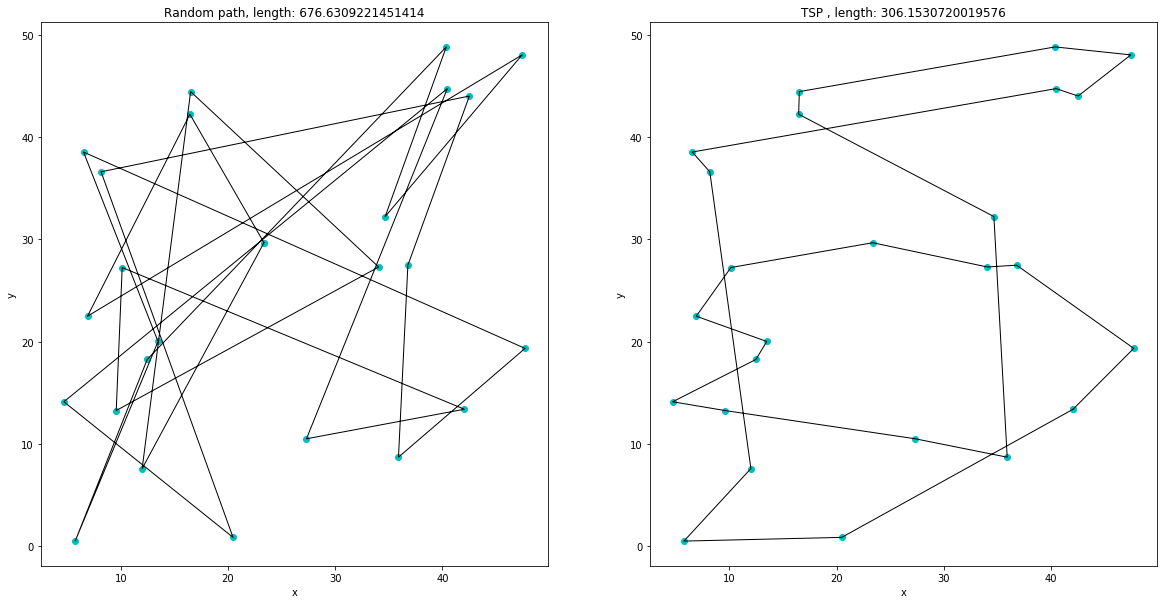

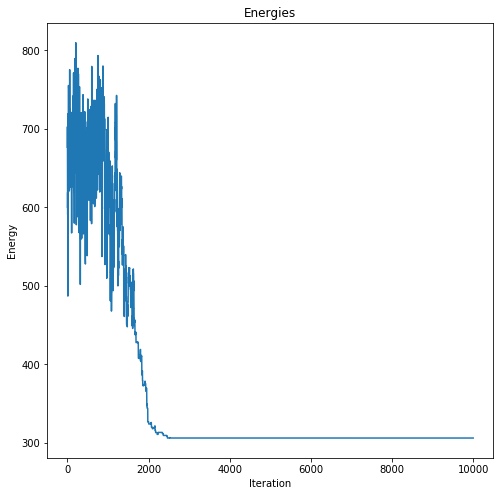

In [10]:
N = 25
points = generate_uniform(N)
energies = []
simulated_annealing()

### Rozkład normalny z czterema różnymi grupami parametrów

N =  25


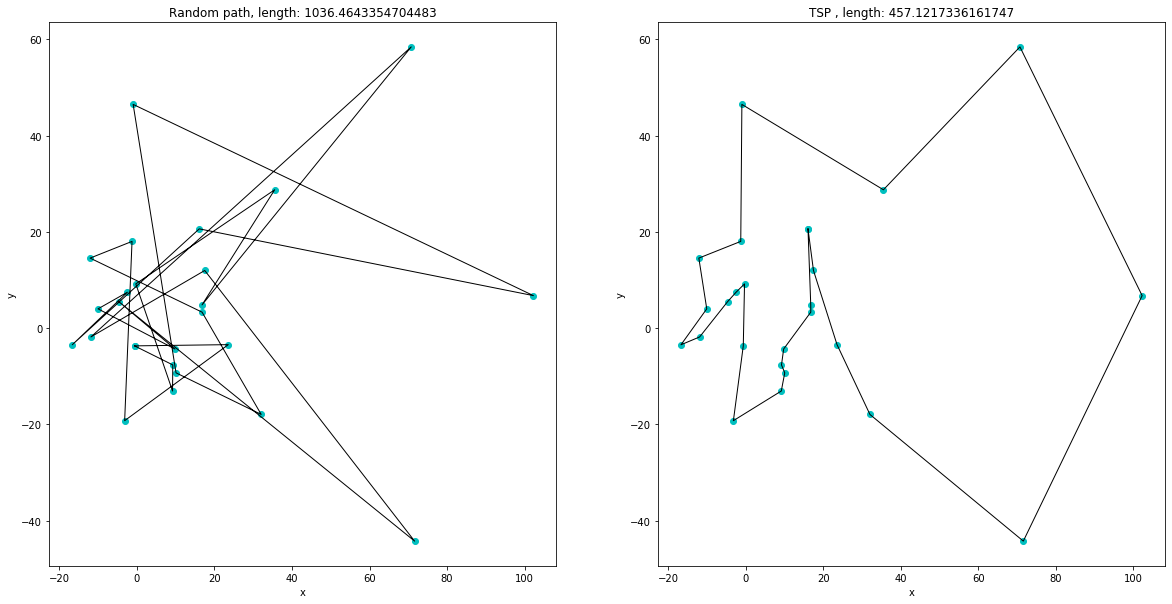

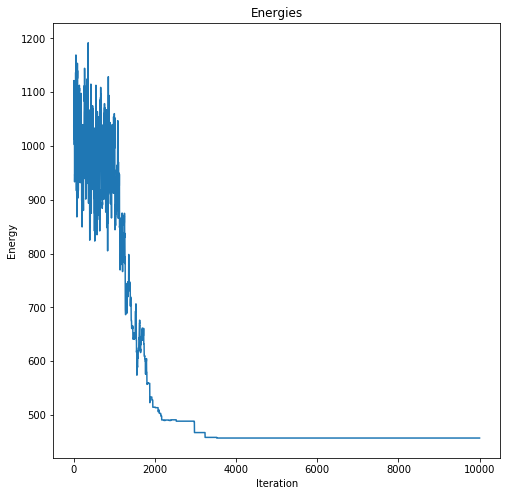

In [11]:
points = generate_normal(N)
energies = []
simulated_annealing()

### Dziewięć odseparowanych grup punktów

N =  25


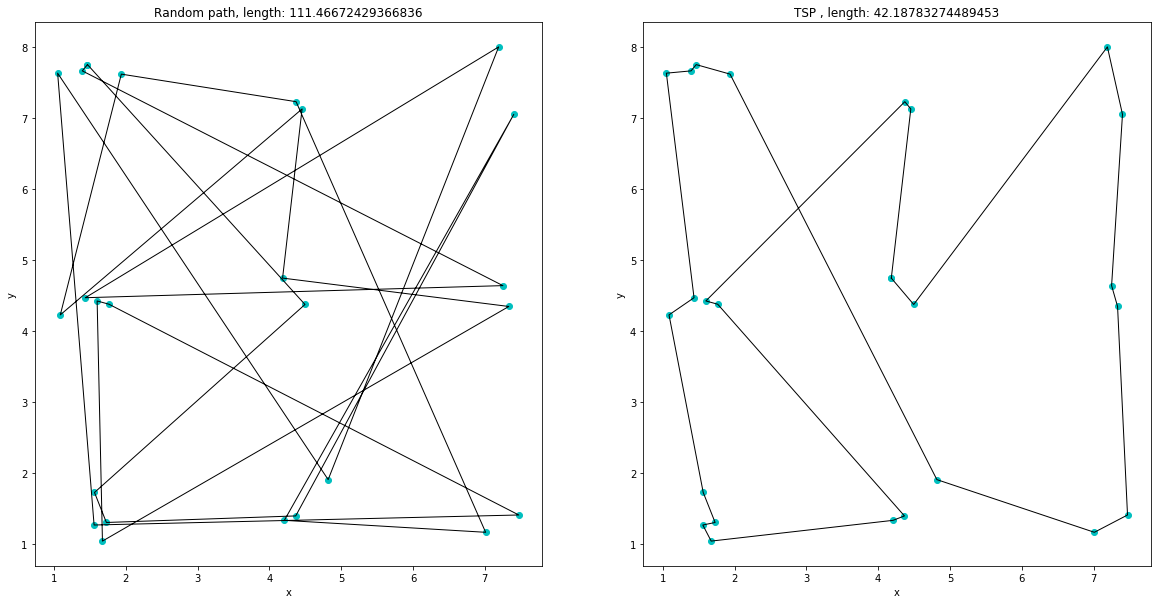

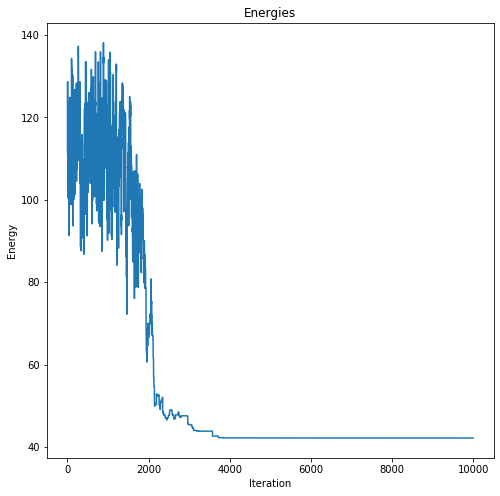

In [12]:
points = generate_nine(N)
energies = []
simulated_annealing()

## Liczba punktów: N = 50
### Rozkład jednostajny

N =  50


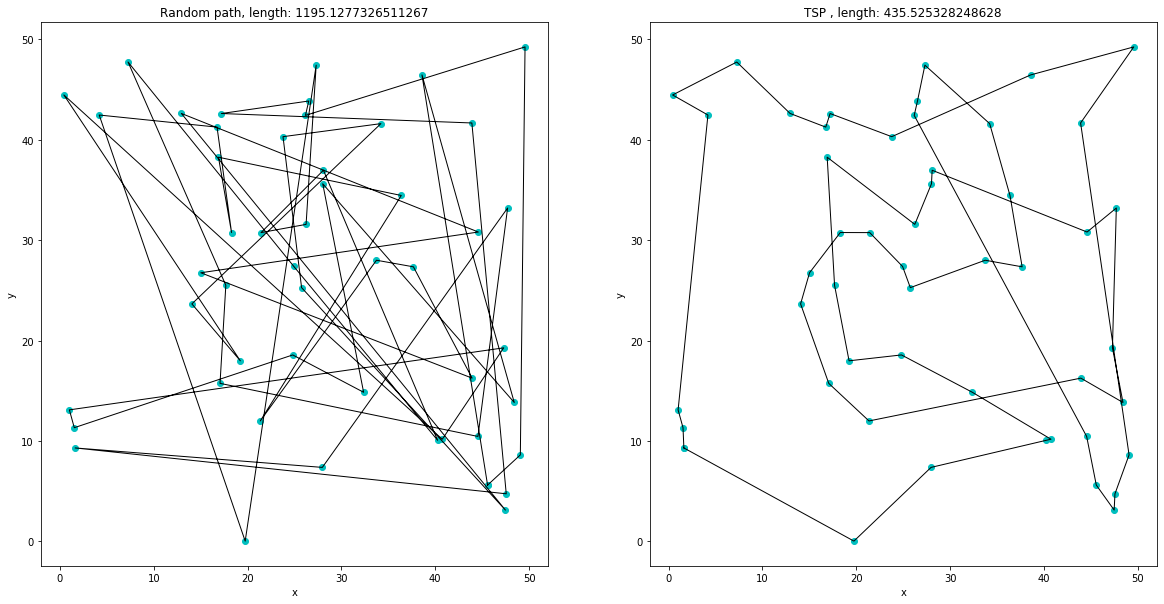

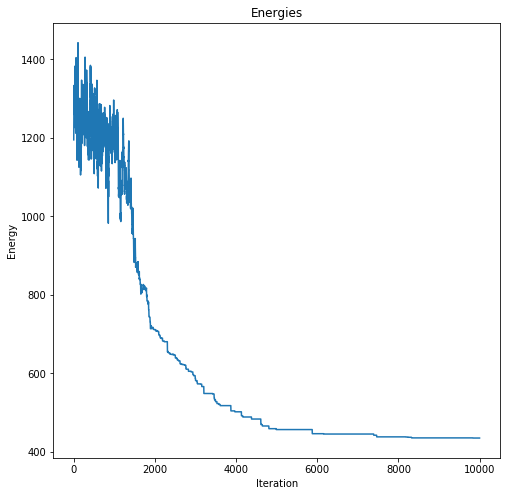

In [13]:
N = 50
points = generate_uniform(N)
energies = []
simulated_annealing()

### Rozkład normalny z czterema różnymi grupami parametrów

N =  50


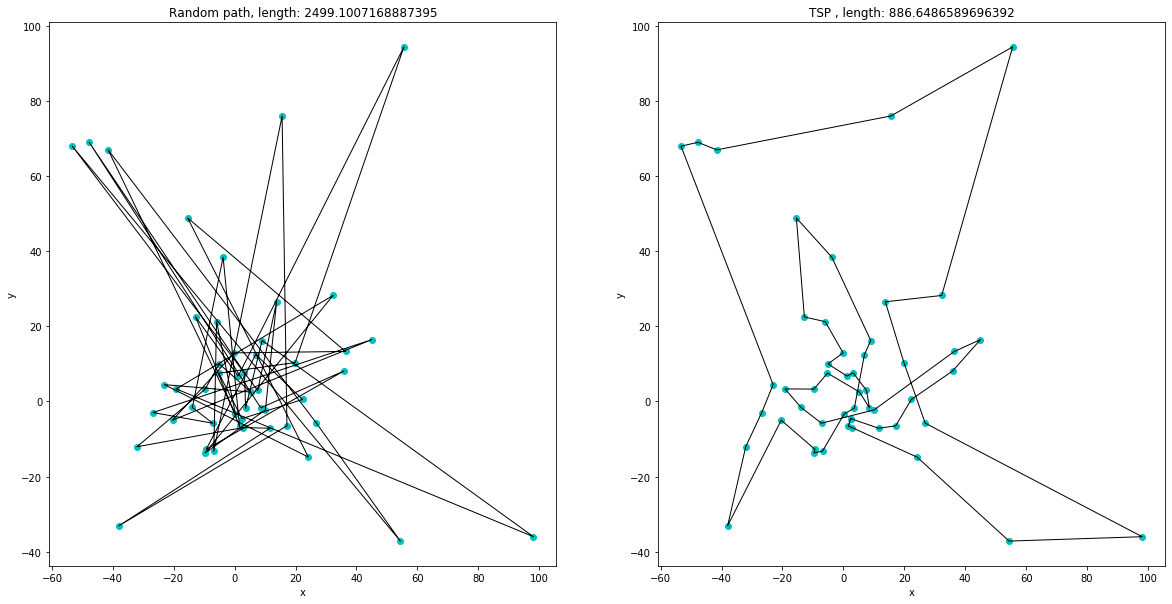

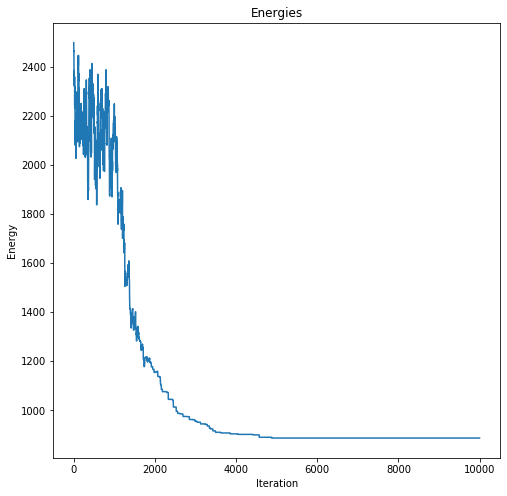

In [14]:
points = generate_normal(N)
energies = []
simulated_annealing()

### Dziewięć odseparowanych grup punktów

N =  30


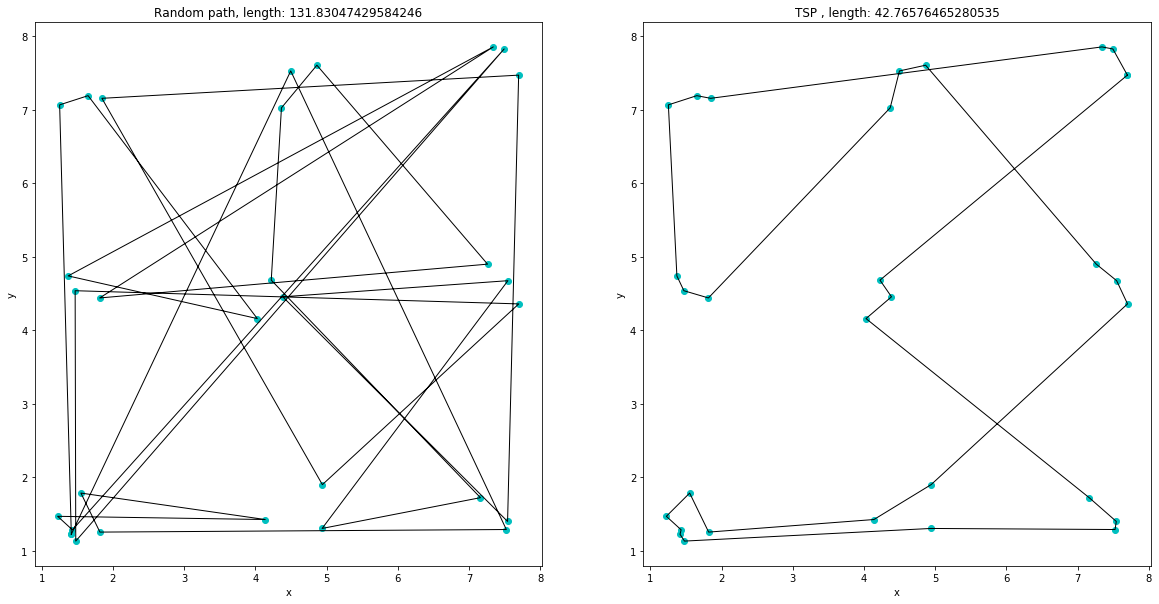

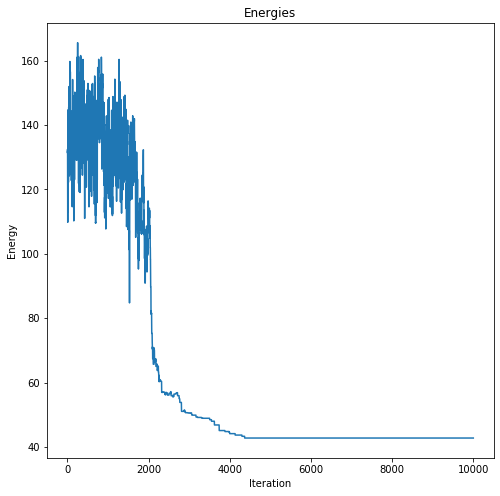

In [37]:
points = generate_nine(N)
energies = []
simulated_annealing()

## Wnioski:
W każdym przypadku długość ścieżki została znacznie zminimalizowana poprzez zastosowanie algorytmu symulowanego wyżarzania. Można zauważyć, że funkcja energii dąży do minimum, a rosnące wartości mogą oznaczać wychodzenie z lokalnych minimów. W niektórych przypadkach algorytm po znalezieniu minimum, przy dalszych iteracjach zwiększał wartość energii, co prowadziło do znalezienia mniej optymalnego rozwiązania.

W przypadku 9 odseparowanych grup punktów, punkty przeważnie układały się tak, że były połączone w grupie między sobą, a mała ilość krawędzi (przeważnie 2-4) łączyły różne grupy punktów.

## b) Wpływ sposobu generacji sąsiedniego stanu
### Dla rozkładu jednostajnego i liczby punktów N = 30

N =  30


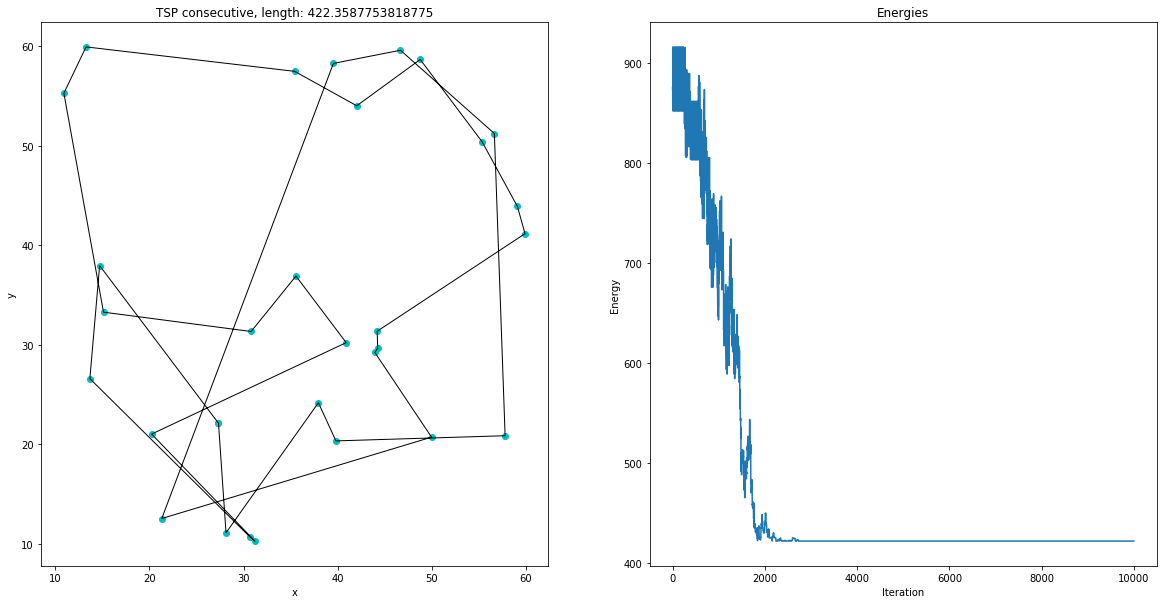

N =  30


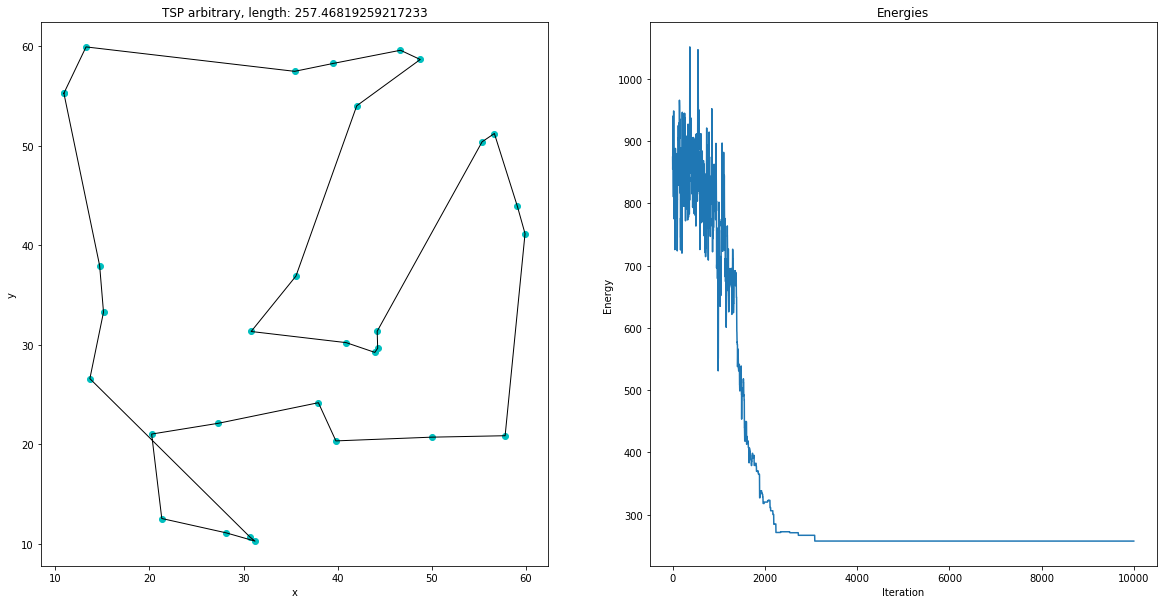

In [17]:
N = 30
points = generate_uniform(N, 10, 60)

energies = []
simulated_annealing("consecutive", show_random=False, name="consecutive")

energies = []
simulated_annealing("arbitrary", show_random=False, name="arbitrary")

### Dla rozkładu normalnego z czterema różnymi grupami parametrów i liczby punktów N = 30

N =  30


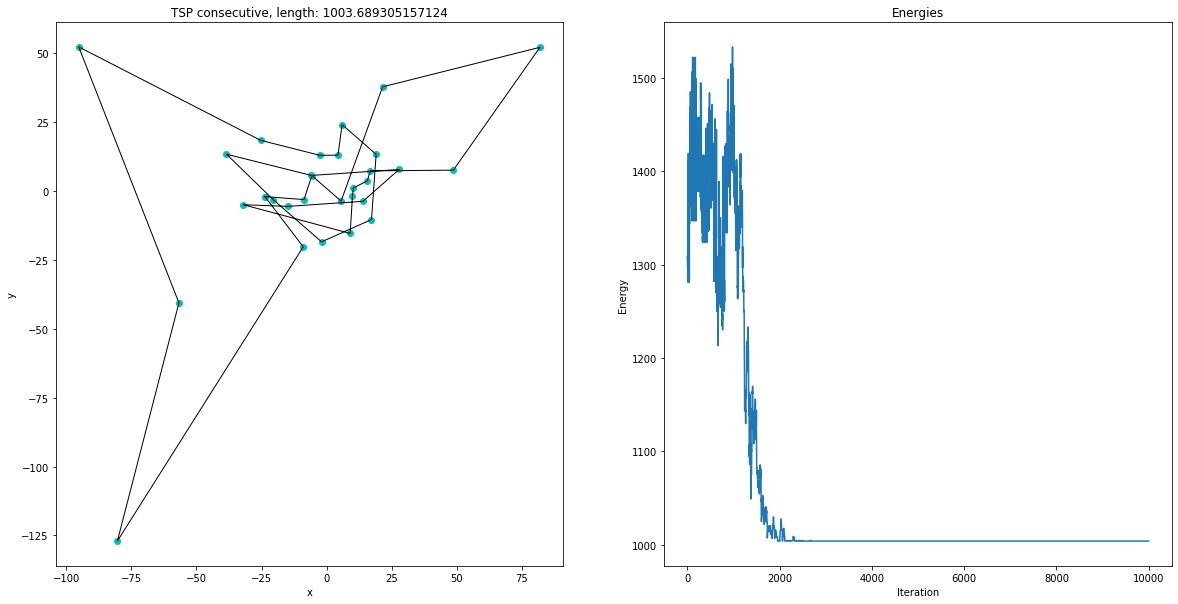

N =  30


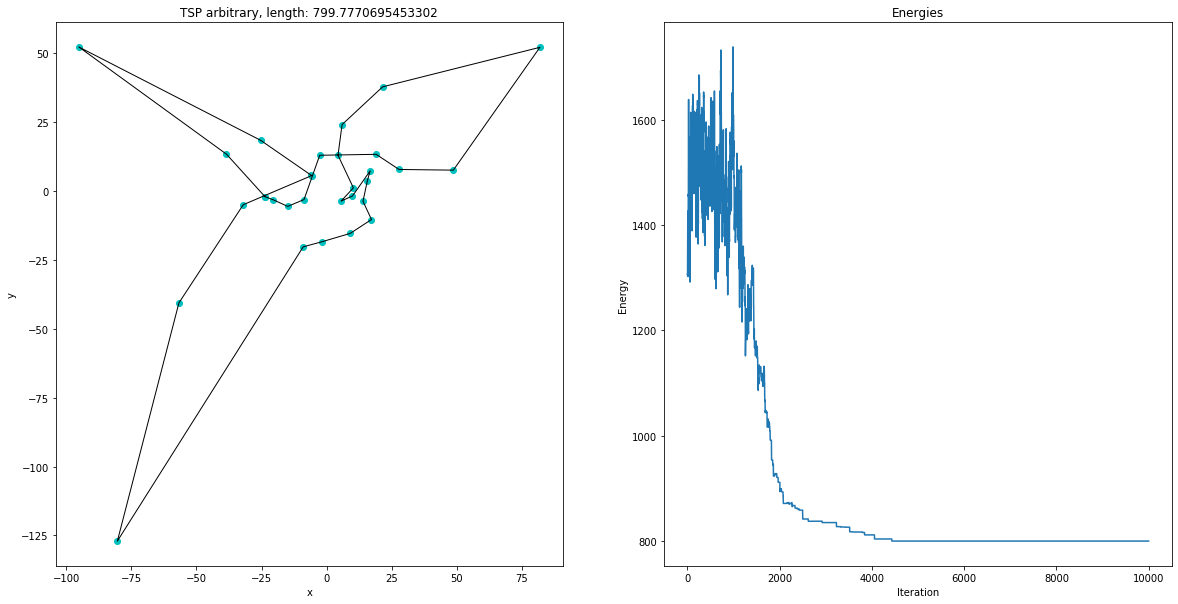

In [18]:
N = 30
points = generate_normal(N)

energies = []
simulated_annealing("consecutive", show_random=False, name="consecutive")

energies = []
simulated_annealing("arbitrary", show_random=False, name="arbitrary")

### Dla dziewięciu odseparowanych grup punktów i liczby punktów N = 30

N =  30


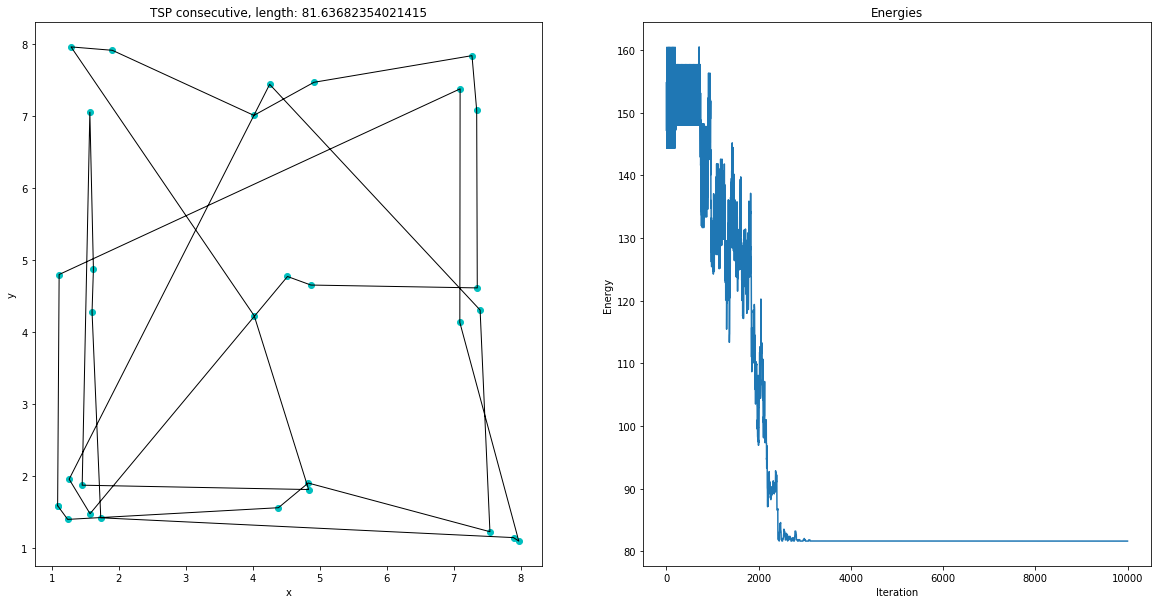

N =  30


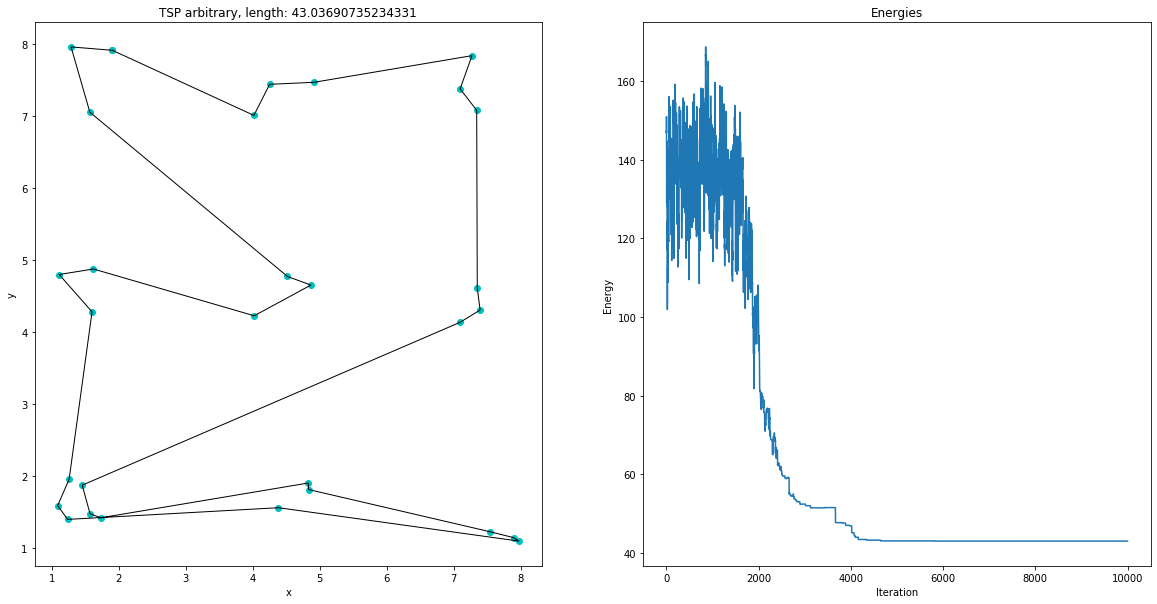

In [19]:
N = 30
points = generate_nine(N)

energies = []
simulated_annealing("consecutive", show_random=False, name="consecutive")

energies = []
simulated_annealing("arbitrary", show_random=False, name="arbitrary")

## b) Wpływ temperatury
### Dla rozkładu jednostajnego i liczby punktów N = 30

N =  30


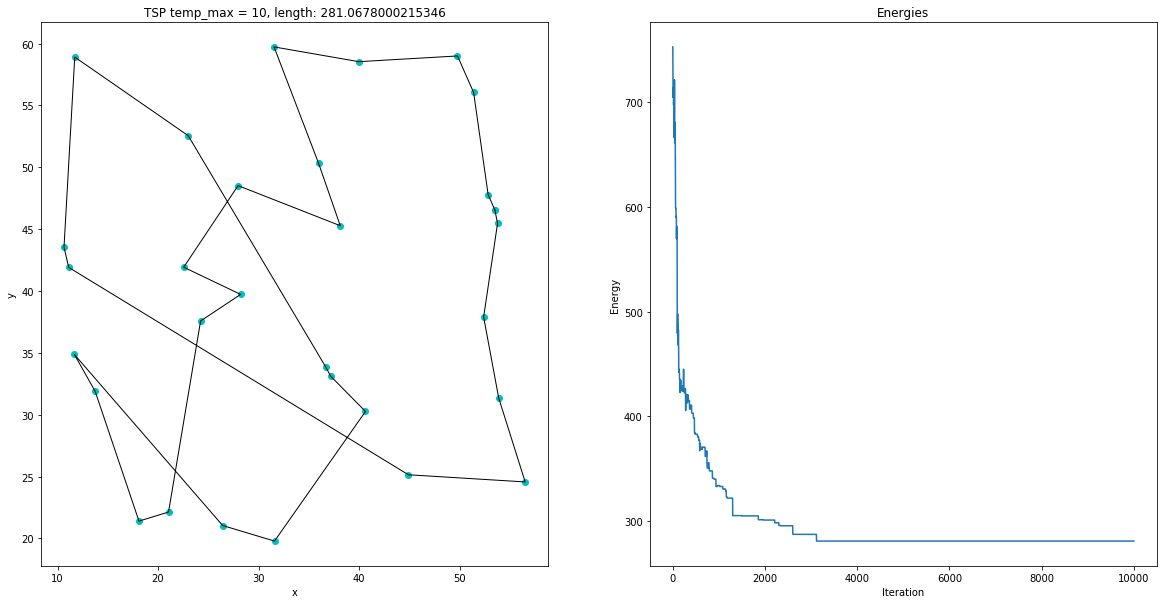

N =  30


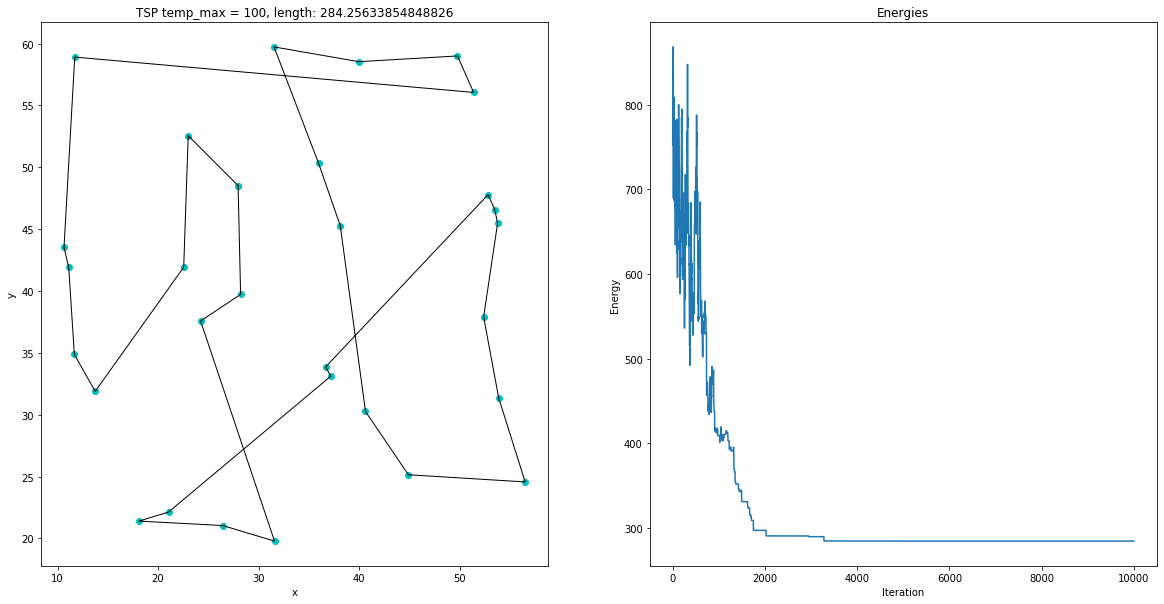

N =  30


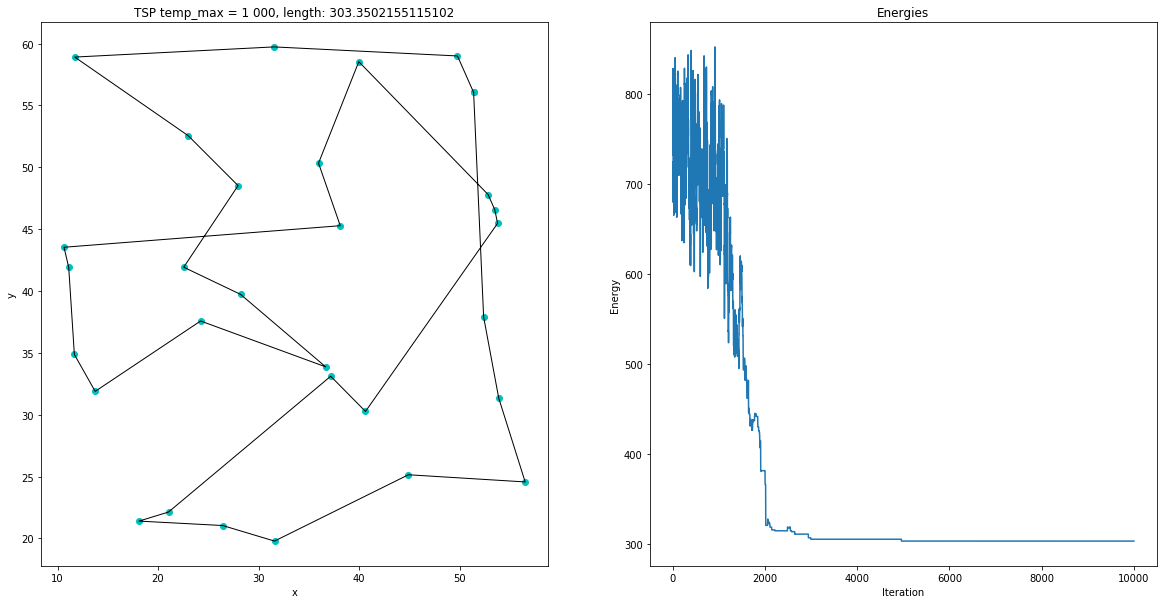

N =  30


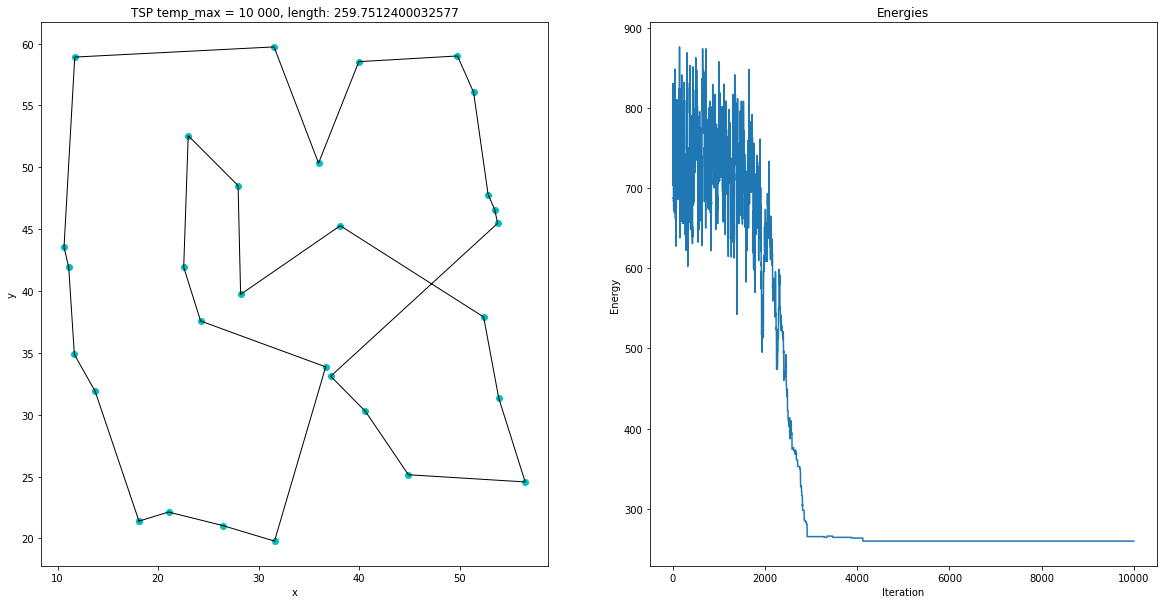

In [33]:
N = 30
points = generate_uniform(N, 10, 60)

energies = []
simulated_annealing(temp_max=10, show_random=False, name="temp_max = 10")

energies = []
simulated_annealing(temp_max=100, show_random=False, name="temp_max = 100")

energies = []
simulated_annealing(temp_max=1000, show_random=False, name="temp_max = 1 000")

energies = []
simulated_annealing(temp_max=10000, show_random=False, name="temp_max = 10 000")

### Dla rozkładu normalnego z czterema różnymi grupami parametrów i liczby punktów N = 30

N =  30


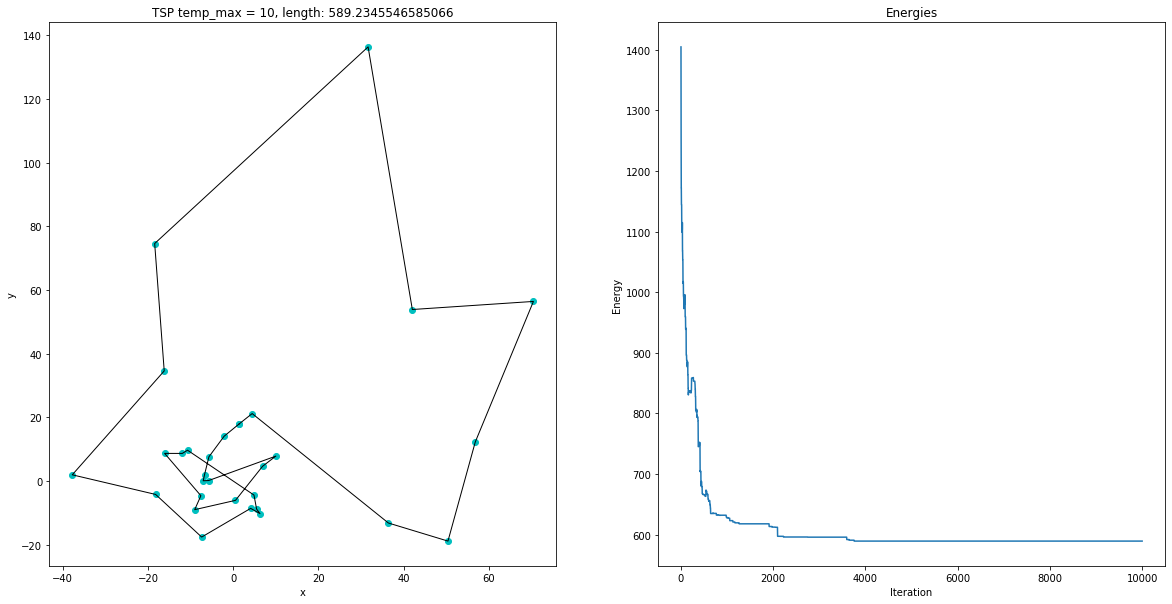

N =  30


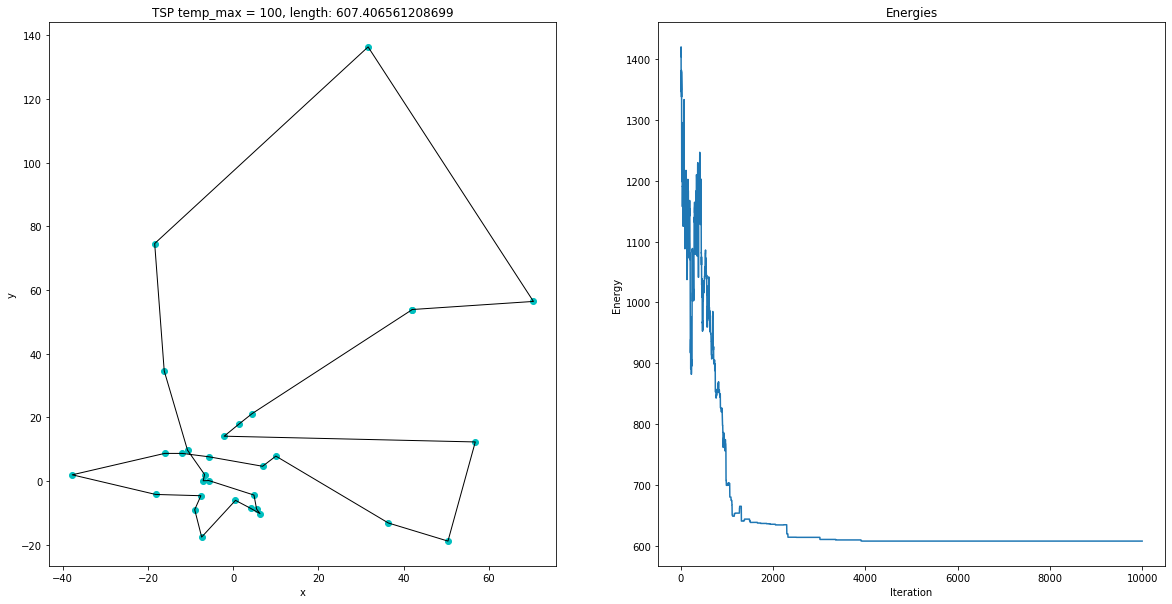

N =  30


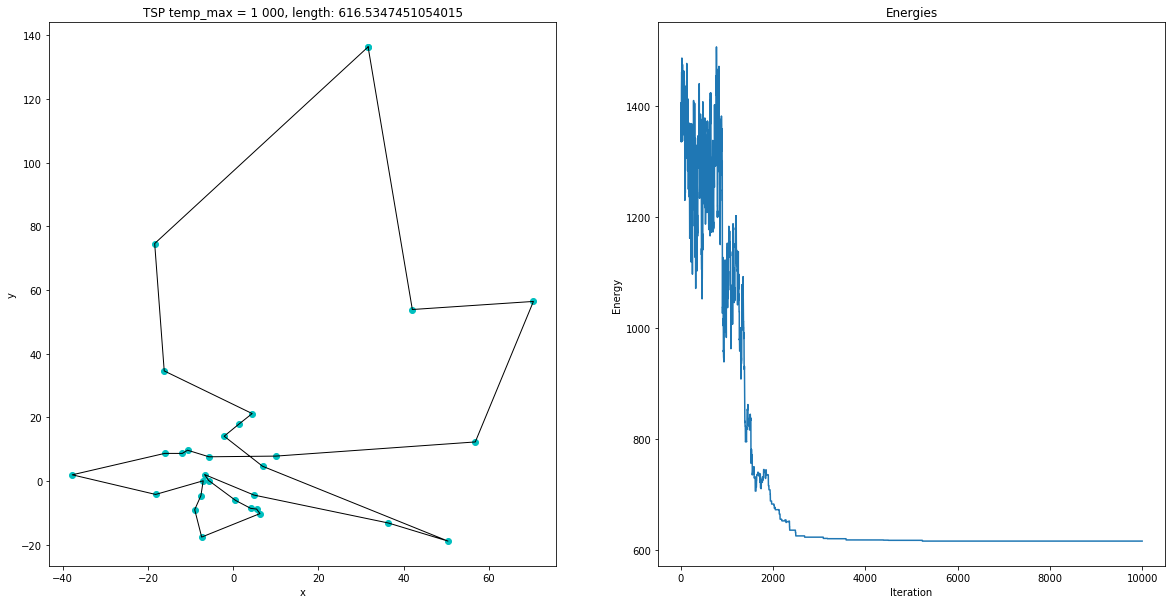

N =  30


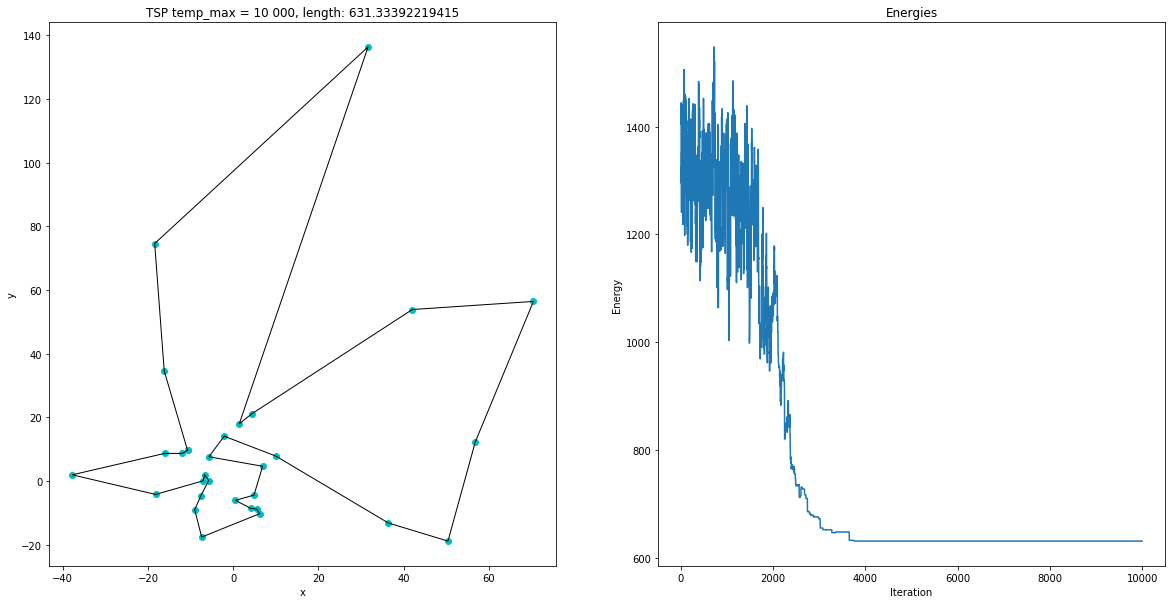

In [34]:
N = 30
points = generate_normal(N)

energies = []
simulated_annealing(temp_max=10, show_random=False, name="temp_max = 10")

energies = []
simulated_annealing(temp_max=100, show_random=False, name="temp_max = 100")

energies = []
simulated_annealing(temp_max=1000, show_random=False, name="temp_max = 1 000")

energies = []
simulated_annealing(temp_max=10000, show_random=False, name="temp_max = 10 000")

### Dla dziewięciu odseparowanych grup punktów i liczby punktów N = 30

N =  30


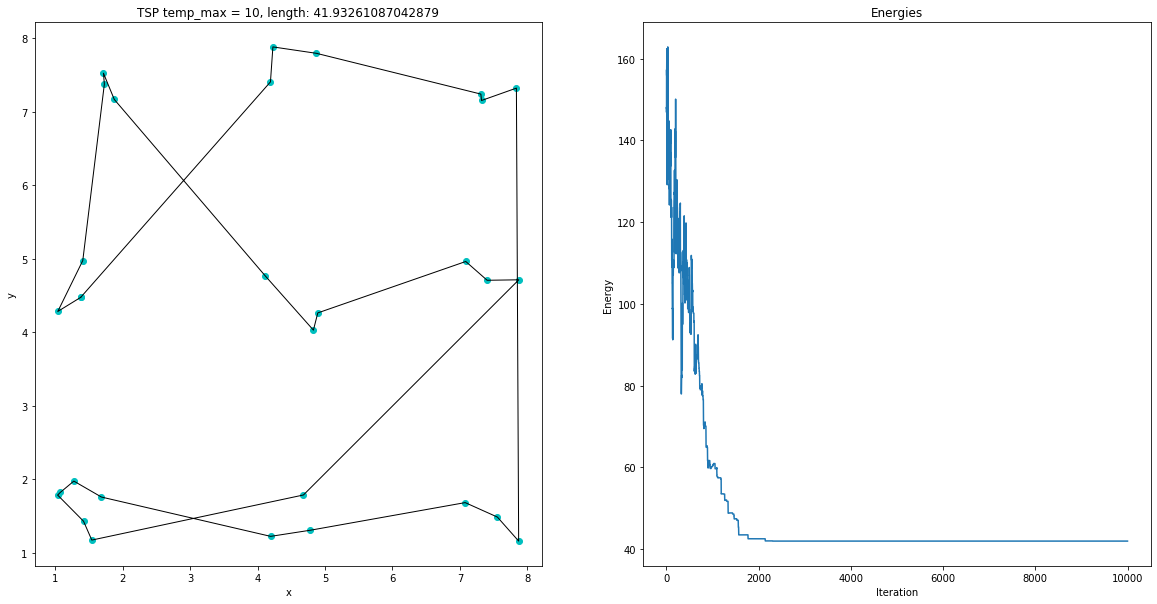

N =  30


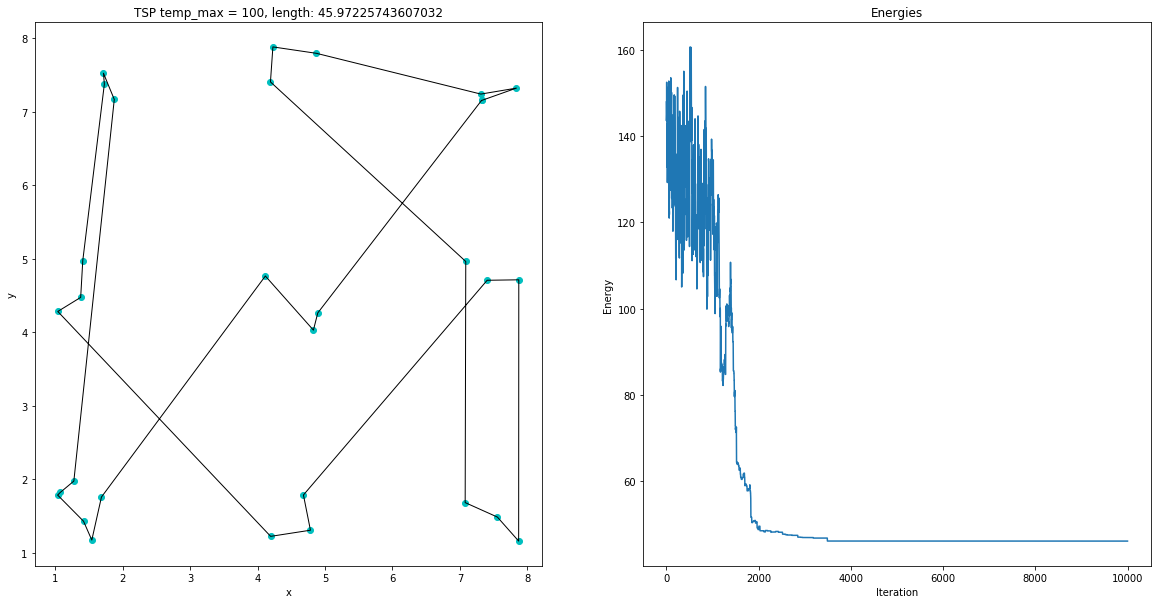

N =  30


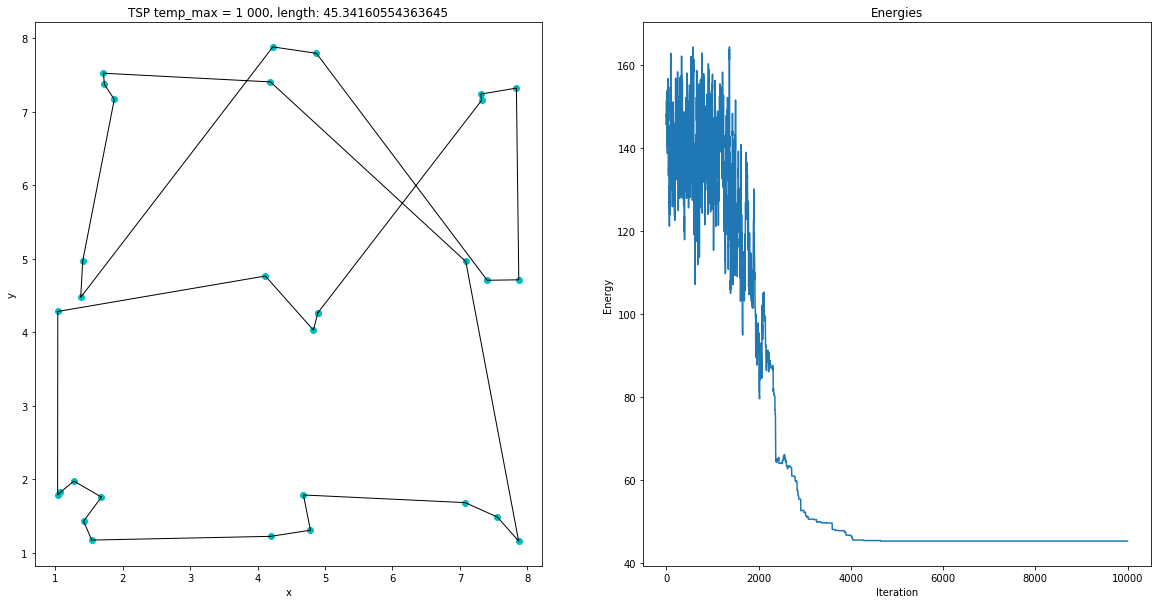

N =  30


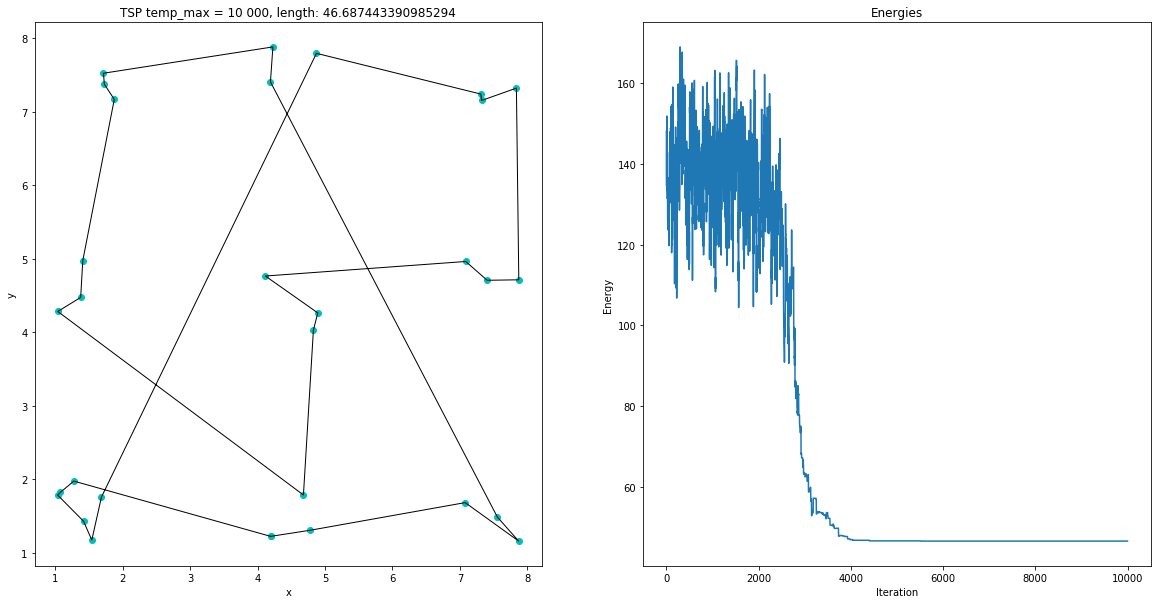

In [36]:
N = 30
points = generate_nine(N)

energies = []
simulated_annealing(temp_max=10, show_random=False, name="temp_max = 10")

energies = []
simulated_annealing(temp_max=100, show_random=False, name="temp_max = 100")

energies = []
simulated_annealing(temp_max=1000, show_random=False, name="temp_max = 1 000")

energies = []
simulated_annealing(temp_max=10000, show_random=False, name="temp_max = 10 000")

## Wnioski:

Metoda *arbitrary swap* daje lepsze rezultaty niż metoda *consecutive swap*. Może to być spowodowane faktem, że druga z metod nie zmienia stosunkowo dużo rozwiązania w porównaniu do pierwszej. Zmieniając kolejnością sąsiednie wierzchołki zmiana nie jest, aż tak widoczna.

Parametrem algorytmu, który ma wpływ na prawdopodobieństwo wyboru gorszego rozwiązania jest parametr przeniesiony bezpośrednio z podstaw termodynamicznych algorytmu, czyli temperatura. Im wyższa, tym prawdopodobieństwo wyboru gorszego rozwiązania jest większe. Im niższa, tym algorytm jest bardziej zbliżony w działaniu do typowych metod iteracyjnych, co można zauważyć na wykresach energii i długościach ścieżek w zależności od temperatury. Przeważnie im wyższą temperaturę stosowano, tym długość ścieżki się zwiększała. 

Fakt ten znajduje odzwierciedlenie w drugim ważnym aspekcie algorytmu symulowanego wyżarzania czyli w powolnym ochładzaniu.
Na początku działania algorytmu temperatura jest wysoka, dzięki czemu algorytm może bardzo często zmieniać konfigurację rozwiązania, niejednokrotnie wybierając rozwiązanie gorsze. Wraz z kolejnymi iteracjami algorytmu temperatura spada i wybierane są częściej rozwiązania lepsze. Pod koniec pracy algorytmu, temperatura jest na tyle niska, że prawdopodobieństwo wyboru gorszego rozwiązania jest bliskie zeru. 

Im dłużej algorytm może działać zanim zostanie osiągnięte kryterium zatrzymania tym lepsze może uzyskać wyniki. Ma to jednak wpływ na znaczne wydłużenie czasu jego działania.

Podsumowując mimo, że symulowane wyżarzanie nie gwarantuje pozostania przy najlepszym rozwiązaniu to osiągą zadowalające efekty. Ma wiele zastosowań, a jednym z nich jest rozwiązywanie problemu komiwojażera.